**compare two simulations on the ne30 native grid
does zonal averaging, and can focus on a small region**

In [1]:
import sys
print(sys.version)
%matplotlib inline
%run -i ~/Python/pjr3
from jupytext.config import find_jupytext_configuration_file
print('jupytext config file is ',find_jupytext_configuration_file('.'))

#import warnings
#warnings.simplefilter("error")


ne30area = '~/NetCDF_Files/F2010_PJR1.eam.h0.0001-01.nc'
DSA = xr.open_mfdataset(ne30area)
lon = xr_getvar('lon',DSA)
lat = xr_getvar('lat',DSA)
area = xr_getvar('area',DSA)

3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 08:57:19) [GCC 11.3.0]
pjr3.py complete
jupytext config file is  /home/jupyter-adminphil/.config/jupytext


In [2]:
def setfig3b1x1 ():
    """
    return fig and axes for a single panel figure
    """
    plotproj = ccrs.Mollweide()
    plotproj._threshold /= 100.
    fig, axes = plt.subplots(ncols=1,
                             gridspec_kw={'width_ratios': [1]},
                             subplot_kw={'projection': plotproj},
                             figsize=(6,3),
                            )
    fig.set_dpi(300.0)
    return fig, axes;

def pltllbox(xri, yri):
    if xri[1] < xri[0]:
        xri[1] += 360.
    regcx = [xri[0],xri[1],xri[1],xri[0],xri[0]]
    regcy = [yri[0],yri[0],yri[1],yri[1],yri[0]]
    plt.plot(regcx,regcy,color='red',transform=ccrs.PlateCarree())
    
def getvarDS(Varname,fstring,case_start,case_end,regtag=''):
    """getvar DS
       get variable from file specifying the formatting of the dataset file names
    """
    ind = fstring % (case_start,Varname,case_end)
    print('opening',ind)
    DS = xr.open_mfdataset(ind).chunk({'time': 12}).transpose('ncol'+regtag,...) 
    DS = center_time(DS)
    #DS.coords['lon'] = (DS.coords['lon'] + 180) % 360 - 180
    #DS = DS.sortby(DS.lon)
    Var = xr_getvar(Varname,DS)
    #VM = Var.mean(dim='time',keep_attrs=True)
    return Var;

def derfldDS(VN, fstring1, case_start1, case_end1):
    """ calculate some derived fields specifying formatting of file names
    RESTOM is Top of Model Residual energy imbalance (In - Out)
    PRECT is total precip
    """
    if VN == 'RESTOM':    
        FSNT = getvarDS('FSNT', fstring1, case_start1, case_end1)
        FLNT = getvarDS('FLNT', fstring1, case_start1, case_end1)
        RESTOM = FSNT - FLNT
        RESTOM = RESTOM.rename('RESTOM')
        RESTOM.attrs['long_name'] = 'TOA imbalance'
        return RESTOM   
    elif VN == 'PRECT':
        PRECL = getvarDS('PRECL', fstring1, case_start1, case_end1)
        PRECC = getvarDS('PRECC', fstring1, case_start1, case_end1)
        PRECT = PRECL+PRECC
        PRECT = PRECT.rename('PRECT')
        PRECT.attrs['long_name'] = 'total precipitation (liq + ice)'
        return PRECT
    elif VN == "DPOG": 
        Varname = 'T'
        ind = fstring1 % (case_start1,Varname,case_end1)
        print('opening',ind)
        DS = xr.open_mfdataset(ind).chunk({'time': 12}).transpose('ncol',...) 
        DS = center_time(DS)
        #DS.coords['lon'] = (DS.coords['lon'] + 180) % 360 - 180
        #DS = DS.sortby(DS.lon)
        Var = xr_getvar(Varname,DS)
        # special treatment for constructing a 3D pressure from PS and
        # hybrid coefs
        VarI = (DS['PS']*DS.hybi + DS.hyai*DS.P0)
        print('VarI',VarI)
        #print('VarI col 0',VarI[0,0,:].values)
        #print('PS',DS['PS'+regtag])
        print('using this variable as a template for DPOG',Varname)
        Var = Var.rename(Varname)
        #print('Var',Var)
        Varx = VarI.diff("ilev").values/9.8
        #print('Varx',Varx.shape)
        Var.data = Varx
        Var.attrs = {}
        #print('new Var col 0', Var[0,0,:].values)
        Var.attrs["units"] = 'kg/m2'
        #Var.attrs["basename"] = 'DPOG'
        Var.attrs["long_name"] = 'DeltaPressure(interfaces)_over_gravity'
#            latr = var.attrs
#            if 'standard_name' in latr.keys():
#                x = Var.attrs.pop("standard_name")
        #print('VarO',Var)
        # make sure the returned quantities have the same coordinate order as standard
        #ldims = list(DS['T'+regtag].dims)
        #Var = Var.transpose(*ldims)
        #print('newPin.dims', Pin.dims)
        #print('newPin.shape', Pin.shape)
        return Var
    else:
        return getvarDS(VN, fstring1, case_start1, case_end1)
    


In [3]:

case_start2 = "/e3sm_prod/phil/climo/cesm/Fixed_SST/ne30pg2/Fixed_SST.cam.h0.1-20."
case_end2 = ".nc"
pref2='CESMcontrol'
fstring2 ='%s%s%s' 

case_start1 = "/e3sm_prod/phil/climo/e3sm/20220930.v2.LR.F2010.E1_CNTL/ne30pg2/20220930.v2.LR.F2010.E1_CNTL.eam.h0.1-14."
case_end1 = ".nc"
fstring1 ='%s%.0s%.0s' 
fstring1 ='%s%s%s' 
pref1='E3SMcontrol'

case_start2 = '/e3sm_prod/e3sm-reshaped/20220930.v2.LR.F2010.E1_CNTL/atm/20220930.v2.LR.F2010.E1_CNTL.eam.h0.1-14.'
case_end2 = '.nc'
pref2='0Tg/yr,R1-3'
fstring2 ='%s%s%s' 

# working from the original files
case_start2 = '/e3sm_prod/mingxuan/archive/20230330.v2.LR.F2010.MCB-SSLT-EM.R1-3.test02/run/*.eam.h0*.nc'
case_end2 = ''
pref2='18Tg/yr,R1-3'
fstring2 ='%s%s%s'
fstring2 ='%s%.0s%.0s'


# working from the time series files
#case_start2 = '/e3sm_prod/mingxuan/archive/20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01/reshaped/20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01.eam.h0.1-6.'
#case_end2 = '.nc'
case_start2 = '/e3sm_prod/phil/tseries/e3sm/20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01/'
case_end2 = '_20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01_000101_002112.nc'
pref2='28Tgpyr,R1-3'
fstring2 ='%s%s%s'

if False:
    # working from the time series files
    #case_start2 = '/e3sm_prod/mingxuan/archive/20230330.v2.LR.F2010.MCB-SSLT-EM.R1-3.test02/reshaped/20230330.v2.LR.F2010.MCB-SSLT-EM.R1-3.test02.eam.h0.1-11.'
    #case_end2 = '.nc'
    case_start2 = '/e3sm_prod/phil/tseries/e3sm/20230330.v2.LR.F2010.MCB-SSLT-EM.R1-3.test02/'
    case_end2 = '_20230330.v2.LR.F2010.MCB-SSLT-EM.R1-3.test02_000101_001112.nc'
    pref2='18Tg/yr,R1-3'
    fstring2 ='%s%s%s'

#


-------------------------------RESTOM
opening /e3sm_prod/phil/climo/e3sm/20220930.v2.LR.F2010.E1_CNTL/ne30pg2/20220930.v2.LR.F2010.E1_CNTL.eam.h0.1-14.FSNT.nc
opening /e3sm_prod/phil/climo/e3sm/20220930.v2.LR.F2010.E1_CNTL/ne30pg2/20220930.v2.LR.F2010.E1_CNTL.eam.h0.1-14.FLNT.nc
opening /e3sm_prod/phil/tseries/e3sm/20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01/FSNT_20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01_000101_002112.nc
opening /e3sm_prod/phil/tseries/e3sm/20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01/FLNT_20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01_000101_002112.nc
DV range, mean -34.74745398395138 7.763041694974557 -1.504872047584497

RESTOM TOA imbalance Range V1 and V2  -126.88318634033203 87.10859680175781 -126.81406501028484 86.32485557800017
V1A 0.685  V2A -0.820


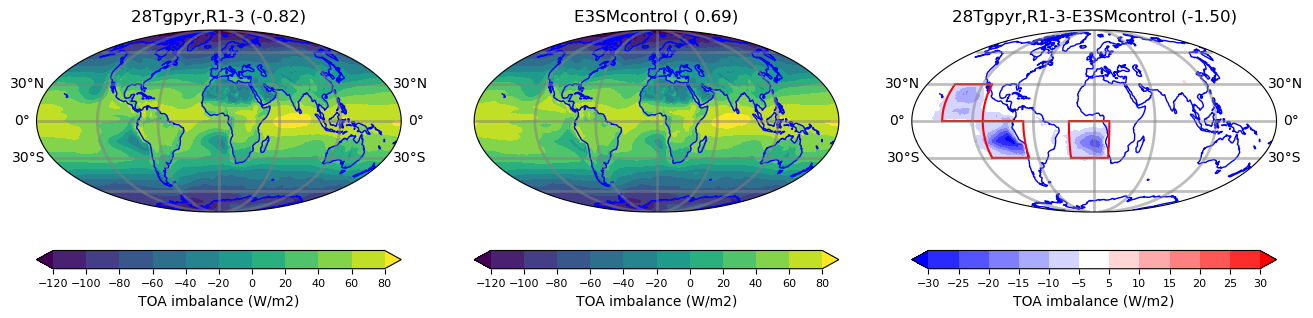

field processing complete

-------------------------------FLNTC
opening /e3sm_prod/phil/climo/e3sm/20220930.v2.LR.F2010.E1_CNTL/ne30pg2/20220930.v2.LR.F2010.E1_CNTL.eam.h0.1-14.FLNTC.nc
opening /e3sm_prod/phil/tseries/e3sm/20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01/FLNTC_20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01_000101_002112.nc
DV range, mean -1.4500044193752615 2.172908829242999 0.02592660947607328

FLNTC Clearsky net longwave flux at top of model Range V1 and V2  124.59840393066406 306.1932373046875 124.96557346251926 306.0526581626738
V1A 263.595  V2A 263.621


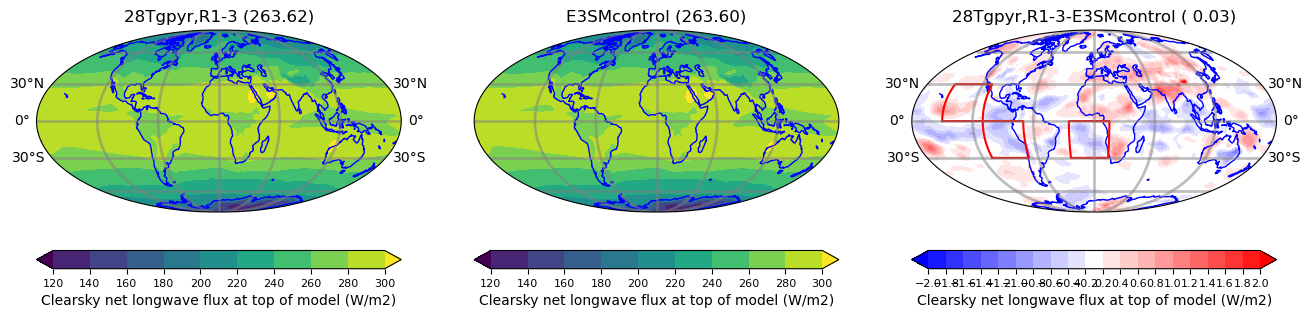

field processing complete

-------------------------------FLNT
opening /e3sm_prod/phil/climo/e3sm/20220930.v2.LR.F2010.E1_CNTL/ne30pg2/20220930.v2.LR.F2010.E1_CNTL.eam.h0.1-14.FLNT.nc
opening /e3sm_prod/phil/tseries/e3sm/20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01/FLNT_20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01_000101_002112.nc
DV range, mean -4.899873362999642 4.664180584911918 0.03692492876572828

FLNT Net longwave flux at top of model Range V1 and V2  125.0648422241211 298.96258544921875 125.42700972983205 299.3689337942543
V1A 239.859  V2A 239.896


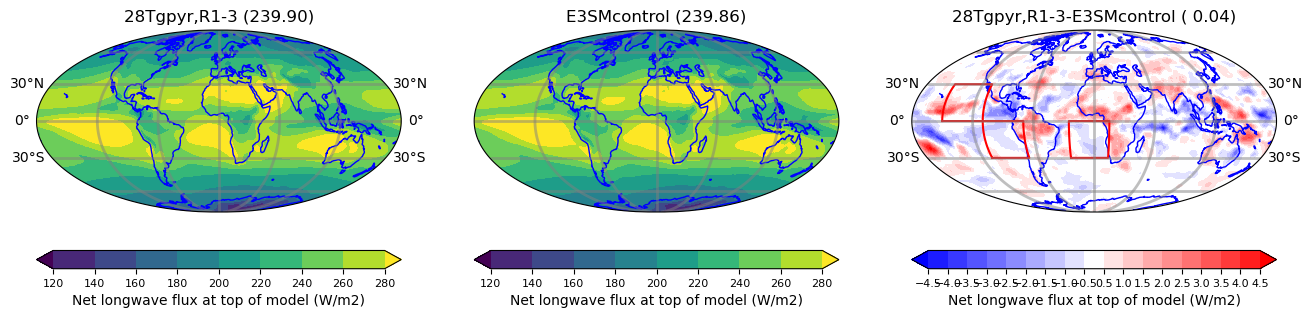

field processing complete

-------------------------------FSNTC
opening /e3sm_prod/phil/climo/e3sm/20220930.v2.LR.F2010.E1_CNTL/ne30pg2/20220930.v2.LR.F2010.E1_CNTL.eam.h0.1-14.FSNTC.nc
opening /e3sm_prod/phil/tseries/e3sm/20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01/FSNTC_20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01_000101_002112.nc
DV range, mean -6.1228580761018065 10.370303432317883 -0.4860939345037991

FSNTC Clearsky net solar flux at top of model Range V1 and V2  51.308326721191406 377.96575927734375 51.20950990049807 377.6530535653769
V1A 288.269  V2A 287.783


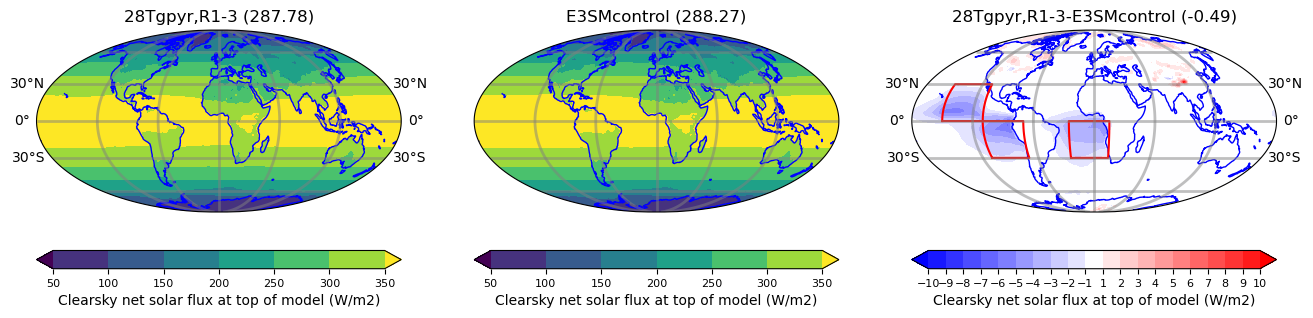

field processing complete

-------------------------------FSNT
opening /e3sm_prod/phil/climo/e3sm/20220930.v2.LR.F2010.E1_CNTL/ne30pg2/20220930.v2.LR.F2010.E1_CNTL.eam.h0.1-14.FSNT.nc
opening /e3sm_prod/phil/tseries/e3sm/20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01/FSNT_20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01_000101_002112.nc
DV range, mean -35.490590343736585 9.425897227745821 -1.4679471154533417

FSNT Net solar flux at top of model Range V1 and V2  50.96609878540039 357.5931701660156 50.84840398895453 354.18042512160855
V1A 240.544  V2A 239.076


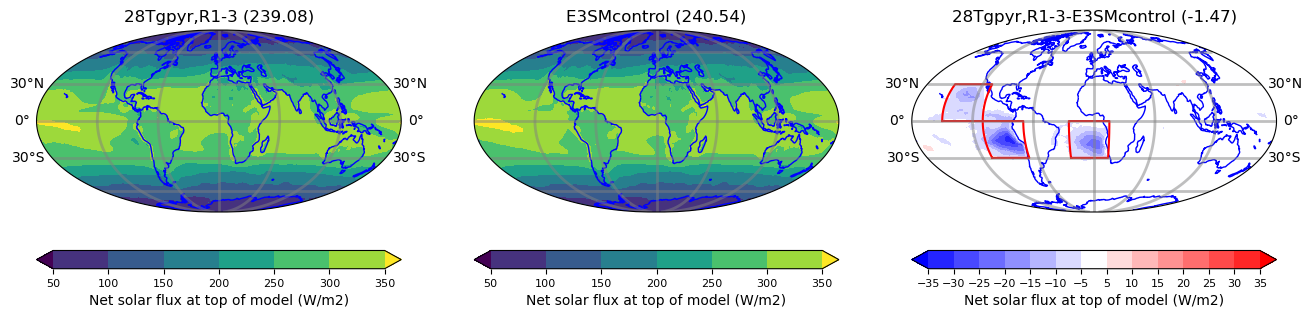

field processing complete

-------------------------------TS
opening /e3sm_prod/phil/climo/e3sm/20220930.v2.LR.F2010.E1_CNTL/ne30pg2/20220930.v2.LR.F2010.E1_CNTL.eam.h0.1-14.TS.nc
opening /e3sm_prod/phil/tseries/e3sm/20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01/TS_20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01_000101_002112.nc
DV range, mean -0.6327722000748395 1.0616897592962005 0.009327590681095899

TS Surface temperature (radiative) Range V1 and V2  212.28656005859375 306.2783203125 212.50670651549694 306.2060562721049
V1A 288.654  V2A 288.664


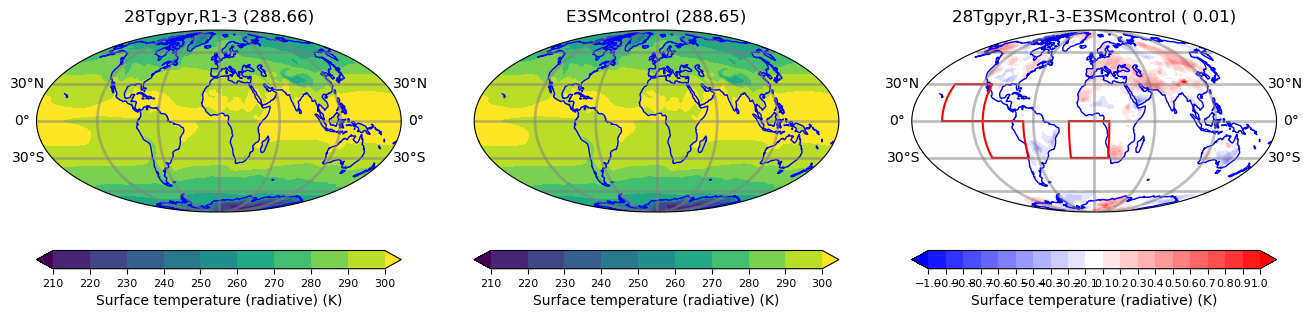

field processing complete

-------------------------------TMQ
opening /e3sm_prod/phil/climo/e3sm/20220930.v2.LR.F2010.E1_CNTL/ne30pg2/20220930.v2.LR.F2010.E1_CNTL.eam.h0.1-14.TMQ.nc
opening /e3sm_prod/phil/tseries/e3sm/20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01/TMQ_20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01_000101_002112.nc
DV range, mean -1.271331713204276 1.0641007137858516 0.06592103553241202

TMQ Total (vertically integrated) precipitable water Range V1 and V2  0.26006004214286804 56.77546310424805 0.266876196074898 56.82851266630786
V1A 25.622  V2A 25.688


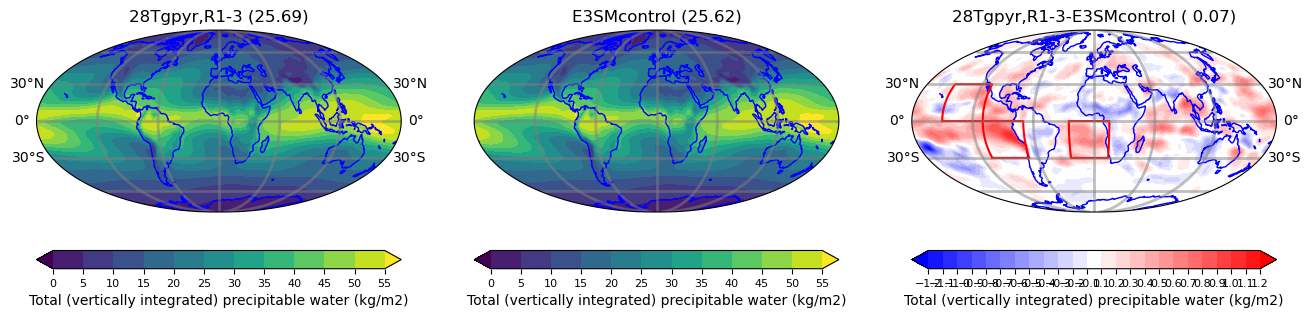

field processing complete

-------------------------------PRECT
opening /e3sm_prod/phil/climo/e3sm/20220930.v2.LR.F2010.E1_CNTL/ne30pg2/20220930.v2.LR.F2010.E1_CNTL.eam.h0.1-14.PRECL.nc
opening /e3sm_prod/phil/climo/e3sm/20220930.v2.LR.F2010.E1_CNTL/ne30pg2/20220930.v2.LR.F2010.E1_CNTL.eam.h0.1-14.PRECC.nc
opening /e3sm_prod/phil/tseries/e3sm/20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01/PRECL_20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01_000101_002112.nc
opening /e3sm_prod/phil/tseries/e3sm/20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01/PRECC_20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01_000101_002112.nc
DV range, mean -1.185007854889827 1.1100300935538705 0.0027584550949515396

PRECT total precipitation (liq + ice) Range V1 and V2  0.034484684467315674 24.37883758544922 0.033528799535298096 24.369863496912284
V1A 3.008  V2A 3.011


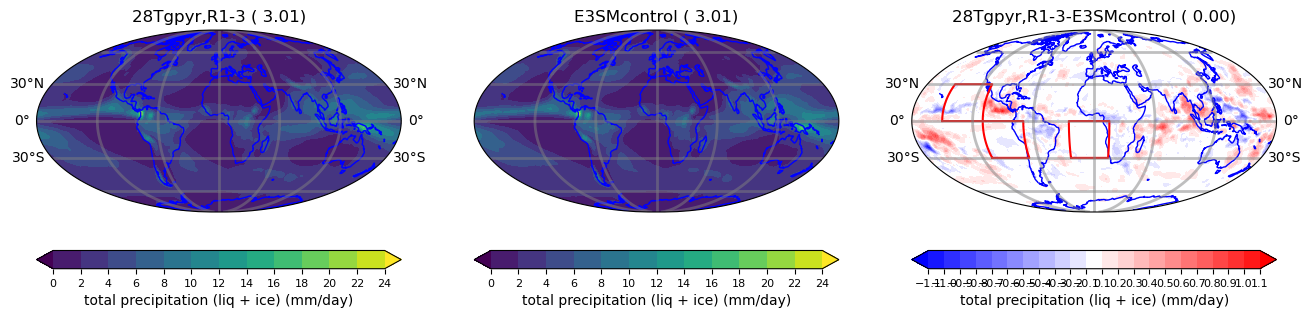

field processing complete

-------------------------------AODVIS
opening /e3sm_prod/phil/climo/e3sm/20220930.v2.LR.F2010.E1_CNTL/ne30pg2/20220930.v2.LR.F2010.E1_CNTL.eam.h0.1-14.AODVIS.nc
opening /e3sm_prod/phil/tseries/e3sm/20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01/AODVIS_20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01_000101_002112.nc
DV range, mean -0.021237273013677282 0.1957388989865509 0.013586897238595547

AODVIS Aerosol optical depth 550 nm Range V1 and V2  0.012817764654755592 1.0900251865386963 0.01279804343532743 1.111299230371203
V1A 0.163  V2A 0.177


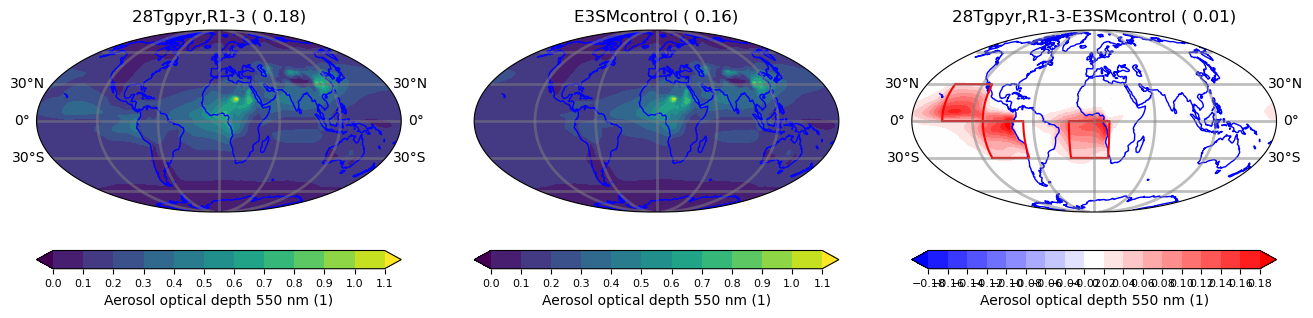

field processing complete

-------------------------------CLDLOW
opening /e3sm_prod/phil/climo/e3sm/20220930.v2.LR.F2010.E1_CNTL/ne30pg2/20220930.v2.LR.F2010.E1_CNTL.eam.h0.1-14.CLDLOW.nc
opening /e3sm_prod/phil/tseries/e3sm/20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01/CLDLOW_20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01_000101_002112.nc
DV range, mean -3.1703120915048864 3.4887026630657942 0.03370519283471651

CLDLOW Vertically-integrated low cloud Range V1 and V2  0.0 96.73140716552734 0.0 96.69863300858489
V1A 39.633  V2A 39.667


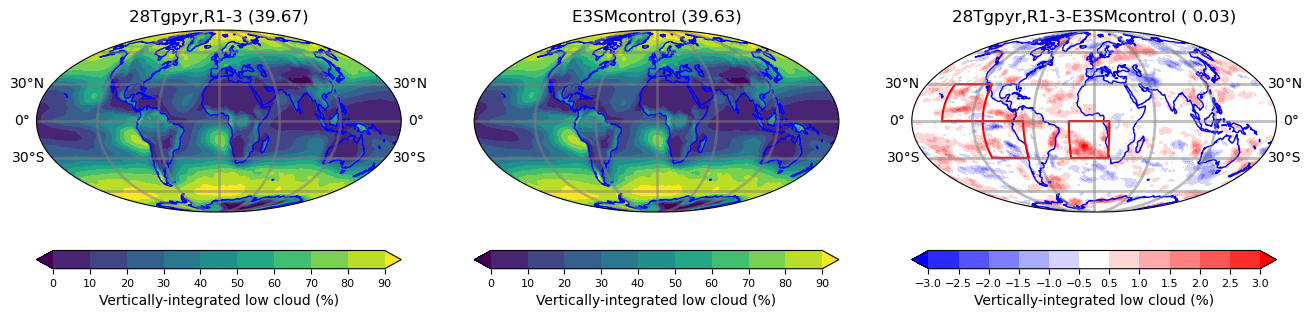

field processing complete

-------------------------------CLDTOT
opening /e3sm_prod/phil/climo/e3sm/20220930.v2.LR.F2010.E1_CNTL/ne30pg2/20220930.v2.LR.F2010.E1_CNTL.eam.h0.1-14.CLDTOT.nc
opening /e3sm_prod/phil/tseries/e3sm/20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01/CLDTOT_20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01_000101_002112.nc
DV range, mean -3.295213810944958 3.921519531304753 0.022827479081911406

CLDTOT Vertically-integrated total cloud Range V1 and V2  17.271696090698242 98.70930480957031 16.71728431452605 98.65544555325644
V1A 67.631  V2A 67.654


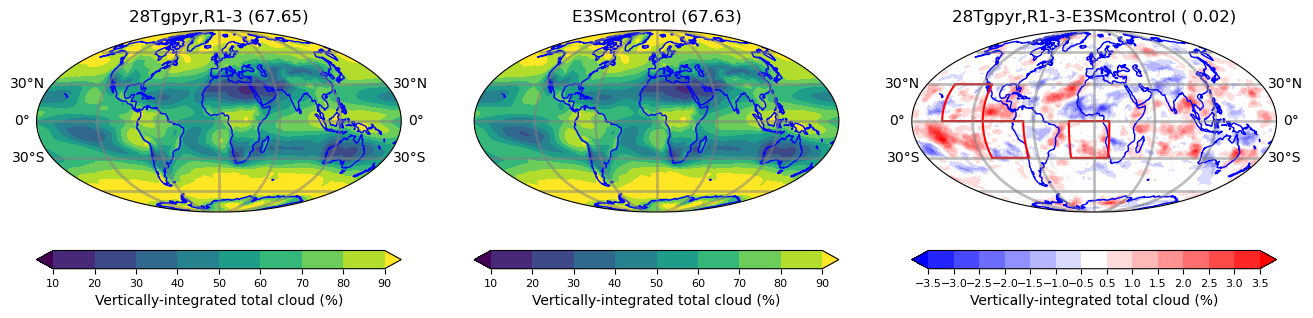

field processing complete

-------------------------------LWCF
opening /e3sm_prod/phil/climo/e3sm/20220930.v2.LR.F2010.E1_CNTL/ne30pg2/20220930.v2.LR.F2010.E1_CNTL.eam.h0.1-14.LWCF.nc
opening /e3sm_prod/phil/tseries/e3sm/20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01/LWCF_20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01_000101_002112.nc
DV range, mean -3.7987028770795064 4.036870252331809 -0.01099838144045151

LWCF LW Cloud Radiative Effect Range V1 and V2  -1.0920754671096802 81.16499328613281 -1.135310072000324 82.27205531132122
V1A 23.736  V2A 23.725


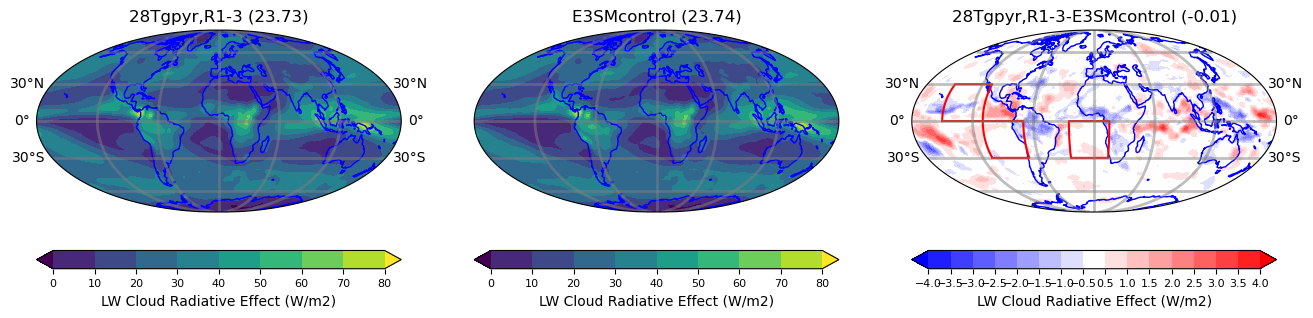

field processing complete

-------------------------------SWCF
opening /e3sm_prod/phil/climo/e3sm/20220930.v2.LR.F2010.E1_CNTL/ne30pg2/20220930.v2.LR.F2010.E1_CNTL.eam.h0.1-14.SWCF.nc
opening /e3sm_prod/phil/tseries/e3sm/20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01/SWCF_20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01_000101_002112.nc
DV range, mean -31.73582706389206 7.073405884794369 -0.9818472297386265

SWCF SW Cloud Radiative Effect Range V1 and V2  -139.23245239257812 -0.20261532068252563 -143.0884831845955 -0.22925415762869641
V1A -47.725  V2A -48.707


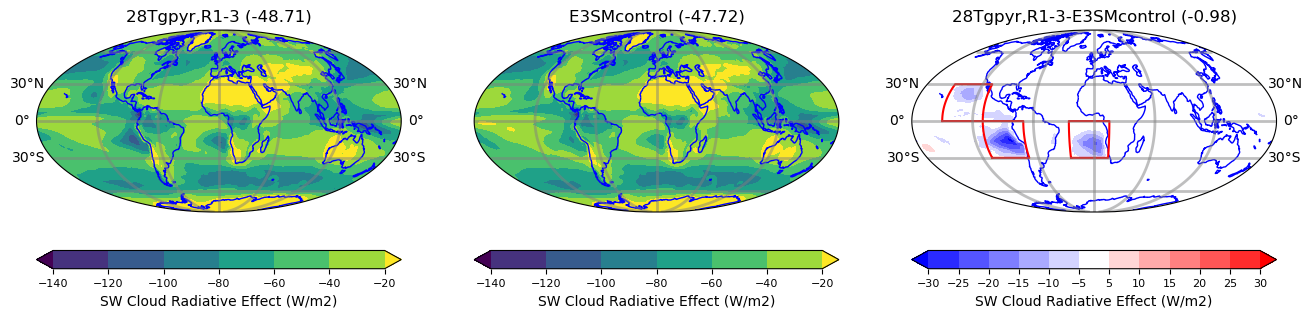

field processing complete

-------------------------------TGCLDIWP
opening /e3sm_prod/phil/climo/e3sm/20220930.v2.LR.F2010.E1_CNTL/ne30pg2/20220930.v2.LR.F2010.E1_CNTL.eam.h0.1-14.TGCLDIWP.nc
opening /e3sm_prod/phil/tseries/e3sm/20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01/TGCLDIWP_20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01_000101_002112.nc
DV range, mean -0.006037798363134603 0.004226137345337205 -4.588277915802512e-05

TGCLDIWP Total grid-box cloud ice water path Range V1 and V2  0.00012514815898612142 0.09539027512073517 0.0001199566466774637 0.0957071995144845
V1A 0.014  V2A 0.014


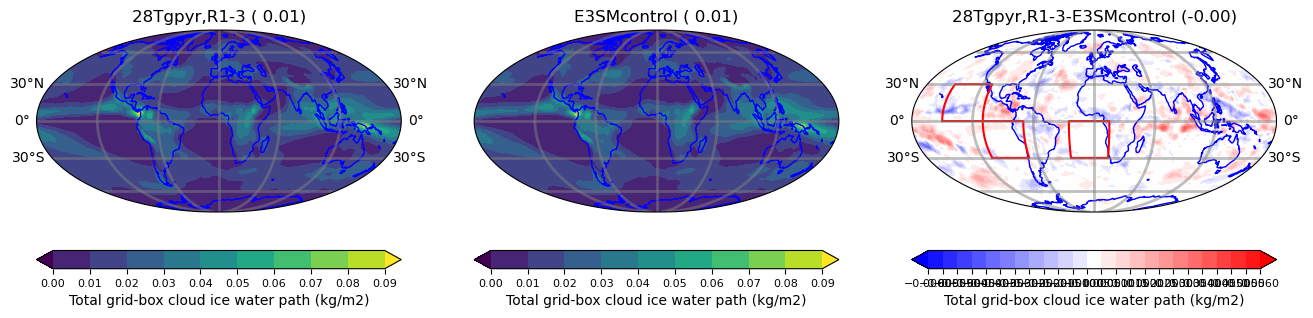

field processing complete

-------------------------------TGCLDLWP
opening /e3sm_prod/phil/climo/e3sm/20220930.v2.LR.F2010.E1_CNTL/ne30pg2/20220930.v2.LR.F2010.E1_CNTL.eam.h0.1-14.TGCLDLWP.nc
opening /e3sm_prod/phil/tseries/e3sm/20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01/TGCLDLWP_20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01_000101_002112.nc
DV range, mean -6.924080161276933 23.430339964526354 0.5197875642324945

TGCLDLWP grid-avg LWP. Range V1 and V2  0.0466797910630703 164.3796844482422 0.06161163106334523 169.63798006459615
V1A 54.329  V2A 54.849


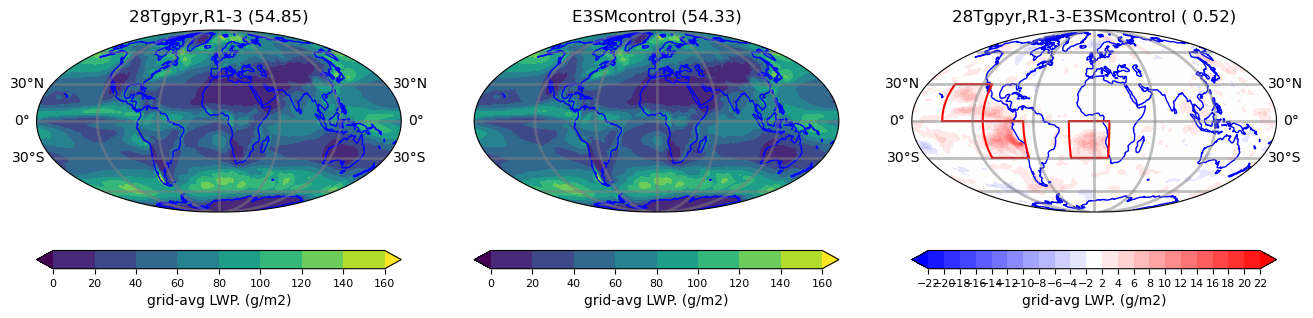

field processing complete

-------------------------------SHFLX
opening /e3sm_prod/phil/climo/e3sm/20220930.v2.LR.F2010.E1_CNTL/ne30pg2/20220930.v2.LR.F2010.E1_CNTL.eam.h0.1-14.SHFLX.nc
opening /e3sm_prod/phil/tseries/e3sm/20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01/SHFLX_20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01_000101_002112.nc
DV range, mean -10.713239980785957 5.727866956010331 -0.04821887155158677

SHFLX Surface sensible heat flux Range V1 and V2  -50.29139709472656 105.93006896972656 -51.09055152788555 104.46770956160117
V1A 20.031  V2A 19.983


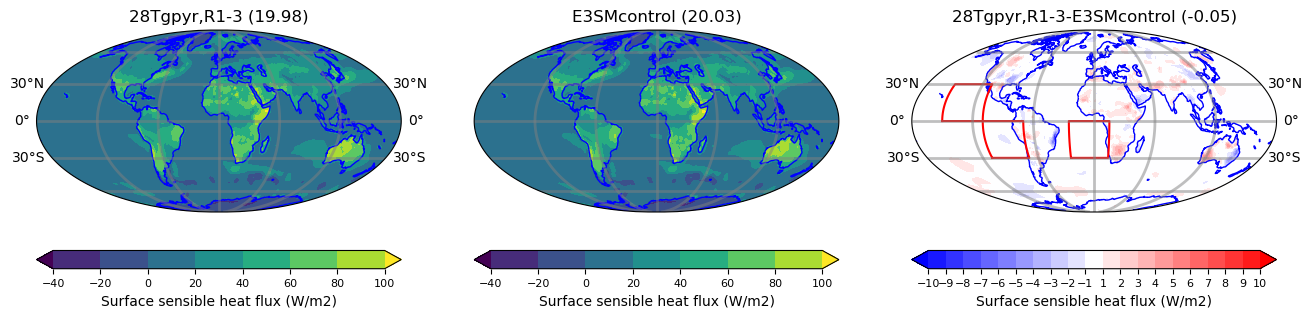

field processing complete

-------------------------------LHFLX
opening /e3sm_prod/phil/climo/e3sm/20220930.v2.LR.F2010.E1_CNTL/ne30pg2/20220930.v2.LR.F2010.E1_CNTL.eam.h0.1-14.LHFLX.nc
opening /e3sm_prod/phil/tseries/e3sm/20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01/LHFLX_20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01_000101_002112.nc
DV range, mean -7.441817530602805 10.31232019413244 0.07703720719305807

LHFLX Surface latent heat flux Range V1 and V2  -1.1038223505020142 267.6748962402344 -1.209782673862738 274.0732760046793
V1A 87.103  V2A 87.180


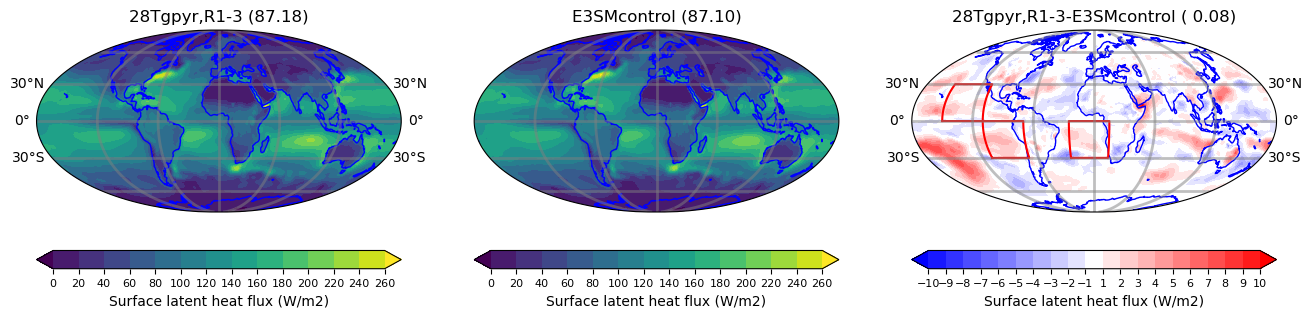

field processing complete

-------------------------------PBLH
opening /e3sm_prod/phil/climo/e3sm/20220930.v2.LR.F2010.E1_CNTL/ne30pg2/20220930.v2.LR.F2010.E1_CNTL.eam.h0.1-14.PBLH.nc
opening /e3sm_prod/phil/tseries/e3sm/20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01/PBLH_20230405.v2.LR.F2010.MCB-SSLT-EM.R1-3.test01_000101_002112.nc
DV range, mean -47.81636435750727 64.9288419301729 0.48390447531812697

PBLH PBL height Range V1 and V2  86.93453979492188 1280.0147705078125 88.58076559764767 1289.3592306576288
V1A 713.626  V2A 714.110


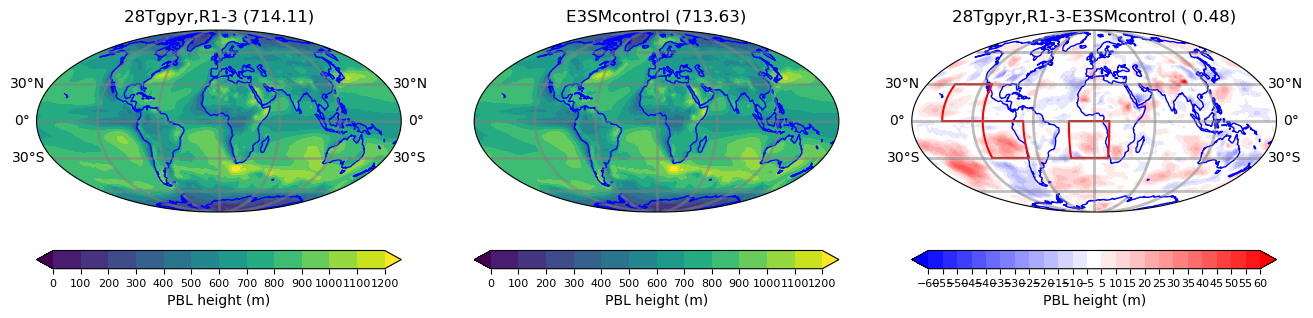

field processing complete


In [4]:
Varlist = np.array(['RESTOM','FLNTC','FLNT','FSNTC','FSNT','TS','TMQ','PRECT','AODVIS','CLDLOW','CLDTOT','LWCF','SWCF','TGCLDIWP','TGCLDLWP',
                    'SHFLX','LHFLX','PBLH'])
#Varlist = np.array(['TS','TMQ','PRECT'])
#Varlist = np.array(['RESTOM','LWCF','SWCF','FLNT','FSNT'])
#Varlist = np.array(['AODVIS'])


for Varname in Varlist:
    print()
    print('-------------------------------'+Varname)
    Var1 = derfldDS(Varname, fstring1, case_start1, case_end1)
    Var1y = tavg_mon_wt(Var1)
    V1 = Var1y.mean('time')
    Var1yga = V1.weighted(area).mean('ncol',keep_attrs=True)
    Var2 = derfldDS(Varname, fstring2, case_start2, case_end2)
    #rint('xx1',Var2.time.units)
    Var2y = tavg_mon_wt(Var2)
    V2 = Var2y.mean('time')
    Var2yga = V2.weighted(area).mean('ncol',keep_attrs=True)

    DV = V2-V1
    print('DV range, mean', DV.min().values, DV.max().values, (Var2yga-Var1yga).values)
    print()
    print(Varname, V1.attrs['long_name'],'Range V1 and V2 ',V1.min().values, V1.max().values, V2.min().values, V2.max().values)

    print('V1A %5.3f' % (Var1yga.values),' V2A %5.3f' % (Var2yga.values))


    clevs = findNiceContours(np.array([V1.values,V2.values]),nlevs = 10)
    dlevs = findNiceContours(np.array([DV.min().values,DV.max().values]),nlevs = 20, rmClev=0.,sym=True)
    #dlevs = [-5.,-2.,-1.,-0.5,-0.2,-0.1,0.1,0.2,0.5,1.,2.,5.]
    #print('xxx',dlevs)
    dmap = diverge_map()
    sV1A = ' (%5.2f)' % Var1yga.values
    sV2A = ' (%5.2f)' % Var2yga.values
    sDVA = ' (%5.2f)' % (Var2yga-Var1yga).values

    if False:
        fig, axes = plt.subplots(ncols=3
                         ,gridspec_kw={'width_ratios': [1, 1, 1]}
                         ,subplot_kw={'projection': ccrs.PlateCarree()}
                         ,figsize=(16,5)
                        )
        plt.savefig('test_'+Vname+'.jpg',format='jpg')
        plt.show()

    plconf = '3-1x1'
    plconf = '1x3'

    # good setup for 1 row of 3 columns
    if plconf == '1x3':
        plotproj = ccrs.Mollweide()
        plotproj._threshold /= 100.
        fig, axes = plt.subplots(ncols=3
                                 ,gridspec_kw={'width_ratios': [1, 1, 1]}
                                 ,subplot_kw={'projection': plotproj}
                                 ,figsize=(16,5)
                                )

#        xr_llhplot(V1, ax=axes[0],clevs=clevs,title=pref1+sV1A)
        xr_cshplot(V1, lon, lat,ax=axes[1],clevs=clevs,ylabels=False,title=pref1+sV1A)
#        xr_llhplot(V2, ax=axes[1],clevs=clevs,ylabels=False,title=pref2+sV2A)
        xr_cshplot(V2, lon, lat,ax=axes[0],clevs=clevs,title=pref2+sV2A)
#        xr_llhplot(DV, ax=axes[2],clevs=dlevs,cmap=dmap,title=pref1+'-'+pref2+sDVA)        
        xr_cshplot(DV, lon, lat,ax=axes[2],clevs=dlevs,cmap=dmap,title=pref2+'-'+pref1+sDVA)
        pltllbox([-150.,-110.],[0.,30.])
        pltllbox([-110.,-70.],[-30.,0.])
        pltllbox([-25.,15.],[-30.,0.])

        #plt.savefig(pref1+'_'+Varname+'.pdf',format='pdf',dpi=300)
        plt.show()

    # good setup for 3 rows of 1 columns
    if plconf == '3-1x1':

        fig, axes = setfig3b1x1()
        xr_cshplot(V2, lon, lat,ax=axes,clevs=clevs,ylabels=False,title=pref2+sV2A)

        pltllbox([-150.,-110.],[0.,30.])
        pltllbox([-110.,-70.],[-30.,0.])
        pltllbox([-25.,15.],[-30.,0.])
        plt.savefig(pref2+'_'+Varname+'.pdf',format='pdf',dpi=300)
        plt.show()
        
        fig, axes = setfig3b1x1()
        print('V1XXX',V1)
        xr_cshplot(V1, lon, lat,ax=axes,clevs=clevs,title=pref1+sV1A)

        pltllbox([-150.,-110.],[0.,30.])
        pltllbox([-110.,-70.],[-30.,0.])
        pltllbox([-25.,15.],[-30.,0.])
        plt.savefig(pref1+'_'+Varname+'.pdf',format='pdf',dpi=300)
        plt.show()

        fig, axes = setfig3b1x1()
        xr_cshplot(DV, lon, lat,ax=axes,clevs=dlevs,cmap=dmap,title=pref1+'-'+pref2+sDVA)

        pltllbox([-150.,-110.],[0.,30.])
        pltllbox([-110.,-70.],[-30.,0.])
        pltllbox([-25.,15.],[-30.,0.])

        plt.savefig(pref1+'_'+Varname+'-D.pdf',format='pdf',dpi=300)
        plt.show()


        
    print('field processing complete')



In [5]:
pmask = ((lon > 220) & (lon < 250) & (lat > 15) & (lat < 35))#[0] # select a subregion
pmask = (lon > -999) # select all points
xxx = pmask.load()
colinds = np.where(xxx.values)[0]
#print('xxx',type(colinds), colinds)

subreg 0.7500003953503928 359.2499996046496 -88.93939984132163 88.93939984132163
shape and size of variables (21600,) 21600  number of unmasked cells  21600
removing wrap lon
xxx (179, 360) 0.0 359.0 -89.0 89.0
opening /e3sm_prod/phil/climo/e3sm/20220930.v2.LR.F2010.E1_CNTL/ne30pg2/20220930.v2.LR.F2010.E1_CNTL.eam.h0.1-14.T.nc
VarI <xarray.DataArray (ncol: 21600, time: 1, ilev: 73)>
dask.array<add, shape=(21600, 1, 73), dtype=float64, chunksize=(21600, 1, 73), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0007-12-31 05:00:00
  * ilev     (ilev) float64 0.1 0.1477 0.218 0.3219 ... 981.9 990.5 997.0 1e+03
Dimensions without coordinates: ncol
Attributes:
    units:          Pa
    long_name:      Surface pressure
    standard_name:  surface_air_pressure
    cell_methods:   time: mean
using this variable as a template for DPOG T
Var1yga <xarray.DataArray (lev: 72)>
dask.array<truediv, shape=(72,), dtype=float64, chunksize=(72,), chunktype=numpy.ndarray>
Coordinates:
  * 

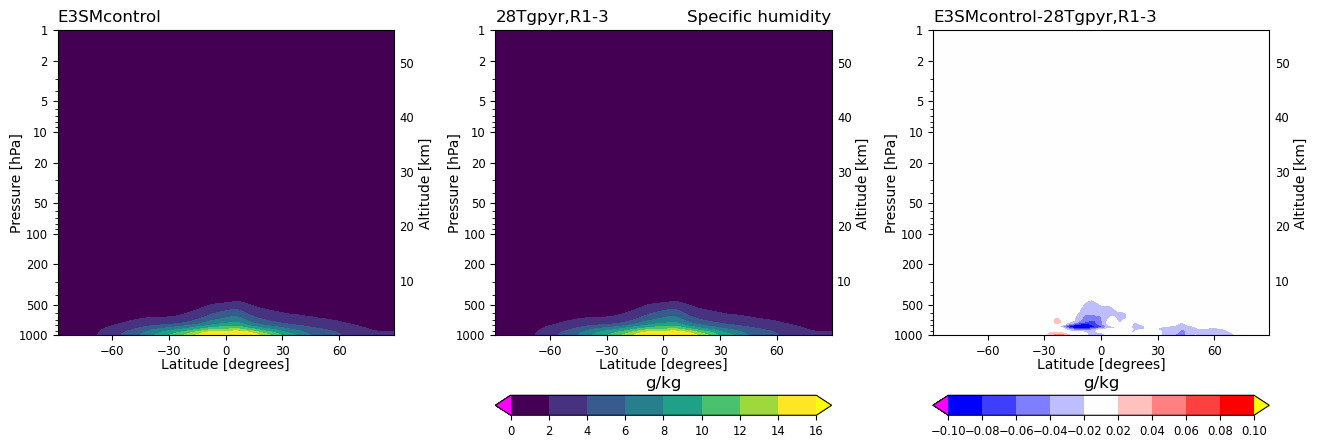

In [6]:
lonsub = lon.isel(ncol=colinds)
latsub = lat.isel(ncol=colinds)
print('subreg',lonsub.min().values,lonsub.max().values, latsub.min().values,latsub.max().values)
#print('subreg size',lonsub.shape)
print('shape and size of variables',lonsub.shape, lonsub.size,' number of unmasked cells ',np.count_nonzero(lonsub.notnull().values))
dinc = 1.  # increment of mesh in degrees
lon_h=np.arange(np.floor(lonsub.min().values),np.ceil(lonsub.max().values+dinc), dinc)
if (np.abs(lon_h[0]-lon_h[-1]%360) < 0.01): # delete wrap lon for creating zonal average
    print('removing wrap lon')
    lon_h = lon_h[0:-1]
    
lat_h=np.arange(np.floor(latsub.min().values),np.ceil(latsub.max().values+dinc), dinc)
xoutm,youtm=np.meshgrid(lon_h,lat_h)
print('xxx',xoutm.shape,xoutm.min(),xoutm.max(),youtm.min(),youtm.max())
areasub = area.isel(ncol=colinds)
wtsh = area.fillna(0)
#print('wtsh',wtsh)
#DPOG1 = xr_getvar('DPOG',DS1,regtag=regtag).isel(ncol=colinds)
Var1 = derfldDS('DPOG', fstring1, case_start1, case_end1).isel(ncol=colinds)
Var1y = tavg_mon_wt(Var1)
V1 = Var1y.mean('time')
DPOG1 = V1
Var1yga = V1.weighted(area).mean('ncol',keep_attrs=True)
print('Var1yga',Var1yga)
weights1 = wtsh*DPOG1
weights1 = weights1.fillna(0)
print('aaa',fstring2, case_start2, case_end2)
Var2 = derfldDS('DPOG', fstring2, case_start2, case_end2).isel(ncol=colinds)
Var2y = tavg_mon_wt(Var2)
V2 = Var2y.mean('time')
Var1yga = V1.weighted(area).mean('ncol',keep_attrs=True)
DPOG2 = V2
print('Var1yga',Var1yga)
weights2 = wtsh*DPOG2
weights2 = weights2.fillna(0)
#print('weights',weights2)

Varlist = np.array(['T','Q','CLOUD','CLDLIQ','ICWMR','CLDICE','RELHUM','NUMICE','NUMLIQ','Mass_bc'])
#                    RESTOM','FLNT','FSNT','TS','TMQ','PRECT','AEROD_v','CLDLOW','CLDTOT','LWCF','SWCF','TGCLDIWP','TGCLDLWP','SHFLX','LHFLX','PBLH','PCONVT','PRECC','PRECS'])
Varlist = np.array(['Q'])
#Varlist = np.array(['RESTOM','LWCF','SWCF','FLNT','FSNT'])

for Vname in Varlist:
    print()
    print('-------------------------------')
    #V1 = xr_getvar(Vname, DS1, regtag).where(pmask).squeeze()
    #V1 = xr_getvar(Vname, DS1, regtag).isel(ncol=colinds).squeeze()
    V1 = derfldDS(Vname, fstring1, case_start1, case_end1).isel(ncol=colinds)
    V1 = tavg_mon_wt(V1)
    V1 = V1.mean('time')
    V2 = derfldDS(Vname, fstring2, case_start2, case_end2).isel(ncol=colinds)
    V2 = tavg_mon_wt(V2)
    V2 = V2.mean('time')
    #V2 = xr_getvar(Vname, DS2, regtag).isel(ncol=colinds).squeeze()
    DV = V1-V2
    print(Vname, V1.attrs['long_name'],'Range V1 and V2 ',V1.min().values, V1.max().values, V2.min().values, V2.max().values)
    V1A = V1.weighted(weights1).mean()
    V2A = V2.weighted(weights2).mean()
    print('mass weight average: V1A %5.3f' % (V1A.values),' V2A %5.3f' % (V2A.values))
    # create regular lat/lon gridding to make zonal averages. Use dataarray to make NaNs easier to process
    Vnew1 = xr.DataArray(interp_ap(xoutm, youtm, V1.values,latsub.values,lonsub.values), 
                        coords={'lat': lat_h,'lon': lon_h,'lev': V1.lev.values}, 
                        dims=["lat", "lon","lev"])
    Vnew1_xa = Vnew1.mean(dim='lon')
    data1 = Vnew1_xa.values.transpose()

    Vnew2 = xr.DataArray(interp_ap(xoutm, youtm, V2.values,latsub.values,lonsub.values), 
                        coords={'lat': lat_h,'lon': lon_h,'lev': V2.lev.values}, 
                        dims=["lat", "lon","lev"])
    Vnew2_xa = Vnew2.mean(dim='lon')
    data2 = Vnew2_xa.values.transpose()

    Vnewd_xa = Vnew1_xa - Vnew2_xa
    dmin = Vnewd_xa.min().values
    dmax = Vnewd_xa.max().values
    print('dmin,dmax',dmin,dmax)

    datad = data1-data2
#       data1 = data1.mean(axis=1).transpose()
    lev = V1['lev'].values
#        plotZMf(data1, lat_h, lev)
    fig, axes = plt.subplots(ncols=3
                             ,gridspec_kw={'width_ratios': [1, 1, 1]}
#                                 ,subplot_kw={'projection': ccrs.PlateCarree()}
                             ,figsize=(16,5)
                            )
    ytop = 1.
    plotZMf(data1, lat_h, lev,axesa=axes[0],plotOpt={'colorbar':"botnd",'units':V1.units,'ltitle':pref1,'ytop':ytop})
    plotZMf(data2, lat_h, lev,axesa=axes[1],plotOpt={'colorbar':"bot",'units':V2.units,'ltitle':pref2,'rtitle':V2.long_name,'ytop':ytop})
    dlevs = findNiceContours(np.array([dmin,dmax]),nlevs = 10, rmClev=0.,sym=True)
    dmap = diverge_map()
    plotZMf(datad, lat_h, lev,axesa=axes[2],plotOpt={'clevs':dlevs,'cmap':dmap,'colorbar':"bot",'units':V2.units,'ytop':ytop,'ltitle':pref1+'-'+pref2})

    #print('attribute check on xarray',hasattr(V1,'units'))
    #plt.savefig('test_'+Vname+'.jpg',format='jpg')
    #plt.tight_layout()
    plt.show()



In [7]:
# next cells not used
help(xr_getvar)
1./0.

Help on function xr_getvar in module __main__:

xr_getvar(Varname, DS, regtag=None, long_name=None)
    get variable Varname from xarray dataset DS
    some variables are derived from others
    some are modified to more traditional units
    some are returned directly from DS
    
    regtag is an optional "region tag" that is added to dimension names on EAM and CAM regional history file



ZeroDivisionError: float division by zero

In [ ]:
# example of locating max of a multidimensional array
a = np.array([[1,2,3],[4,3,1]])
a = np.array([[1,4,3,np.nan],[np.nan,4,3,1]])
af = a.flatten()
afd = af[np.isfinite(af)]
print('a',a)
print('len a, af, afd',len(a), len(af), len(afd))
print('afd max',afd.max())
i,j = np.where(a==a.max())
print('i,j',i,j)
i,j = np.where(a==afd.max())
print('i,j',i,j)
a[i,j]

In [ ]:
from matplotlib import pylab as plt
import numpy

fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid()
# set labels and font size
ax.set_xlabel('X axis', fontsize = 12)
ax.set_ylabel('Y axis', fontsize = 12)

ax.plot(np.random.random(100))

# change font size for x axis
#ax.xaxis.get_label().set_fontsize(20)

plt.show()
ax.xaxis.get_label().get_fontsize()